In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import random
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import time

In [3]:
random.seed(687)

In [4]:
#filename = "/Users/Alexandra/Desktop/Harvard Docs/Classes/6.87/Project_files/rpe1_normalized_singlecell_01.h5ad"
filename = "/Users/Alexandra/Desktop/Harvard Docs/Classes/6.87/Project_files/K562_essential_normalized_singlecell_01.h5ad"
adata = ad.read_h5ad(filename,'r')

In [5]:
gene_transcripts = adata.obs.gene_transcript
unqiue_transcripts = np.unique(gene_transcripts, return_counts=True)

Text(0.5, 1.0, 'Filtered cells per gRNA')

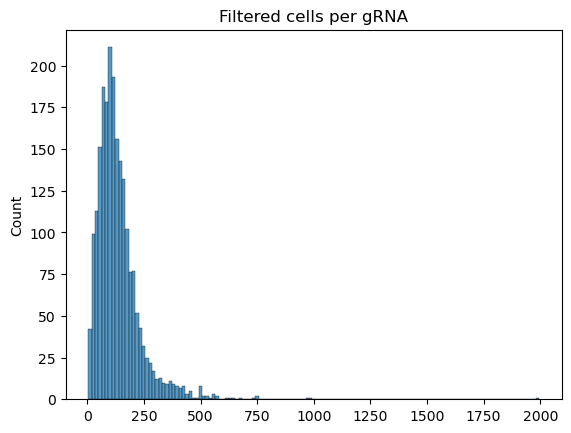

In [7]:
good_grna = ["non-targeting" not in x for x in unqiue_transcripts[0]]
transcript_nums = unqiue_transcripts[1][good_grna]
sns.histplot(transcript_nums)
plt.title("Filtered cells per gRNA")

In [9]:
print(transcript_nums.shape)
print(adata.shape)

(2176,)
(310385, 8563)


Text(0.5, 1.0, 'Filtered cells per gRNA (zoomed in)')

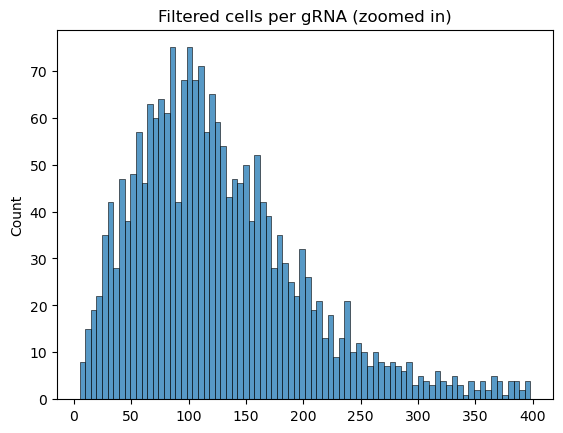

In [6]:
good_grna = ["non-targeting" not in x for x in unqiue_transcripts[0]]
sns.histplot(transcript_nums[transcript_nums<400],bins=80)
plt.title("Filtered cells per gRNA (zoomed in)")

In [10]:
single_trans = adata.obs.gene_transcript == unqiue_transcripts[0][0]
ad_to_df = adata[single_trans,:].to_df()
print("Number of measurements with <10 cells: " + str(sum(transcript_nums<10)) + " out of " + str(len(transcript_nums)))

Number of measurements with <10 cells: 8 out of 2176


In [8]:
start = time.time()

counter = 0
number_splits = 5
min_measurments_per_set = 10

indice_master_list = []

for term in unqiue_transcripts[0]:
    final_list = []

    if counter%100==0:
        print("Round: " + str(counter))
    counter += 1
    good_transcript = adata.obs.gene_transcript == term
    indices_of_transcript = [i for i, val in enumerate(good_transcript) if val]
    shuffled_indices = indices_of_transcript.copy()

    if sum(good_transcript)>=number_splits*min_measurments_per_set:

        random.shuffle(indices_of_transcript)
        min_elements_per_group = len(indices_of_transcript)//number_splits
        remainder_elements = len(indices_of_transcript) - (number_splits*min_elements_per_group)
        num_non_remainder_elements = number_splits - remainder_elements

        list_of_elem_num = [min_elements_per_group+1]*remainder_elements + [min_elements_per_group]*num_non_remainder_elements
        list_of_elem_num = [0] + list_of_elem_num

        indice_shuffled_list = [shuffled_indices[list_of_elem_num[x]:list_of_elem_num[x]+list_of_elem_num[x+1]] for x in range(0, len(list_of_elem_num)-1)]
        final_list = indice_shuffled_list

    elif sum(good_transcript)>= 11:
        enough_entries = 0
        while enough_entries<number_splits:
            random.shuffle(indices_of_transcript)
            group_num = len(indices_of_transcript)//10
            remainder_elements = len(indices_of_transcript) - (10*group_num)

            list_of_elem_num = list(range(0,group_num*10+1,10))
            indice_shuffled_list = [shuffled_indices[list_of_elem_num[x]:list_of_elem_num[x+1]] for x in range(0, len(list_of_elem_num)-1)]

            temp_indices = shuffled_indices[list_of_elem_num[-1]:]
            remaining_indices = list(set(shuffled_indices) - set(temp_indices))
            remaining_nums = random.sample(remaining_indices, 10-len(temp_indices))

            indice_shuffled_list.append(temp_indices + remaining_nums)

            if enough_entries==0:
                final_list = indice_shuffled_list.copy()
                enough_entries += len(indice_shuffled_list)
                random.shuffle(indices_of_transcript)
            else:
                if len(final_list)<(number_splits-enough_entries):
                    final_list = final_list + indice_shuffled_list
                    enough_entries += len(indice_shuffled_list)
                    random.shuffle(indices_of_transcript)
                else:
                    final_list = final_list + indice_shuffled_list[0:number_splits-enough_entries]
                    enough_entries += number_splits-enough_entries
    else:
        final_list = [indices_of_transcript]*number_splits

    indice_master_list.append(final_list)

end = time.time()
print("Dividing into randomized indices: " + str(start-end) + " seconds")


Round: 0
Round: 100
Round: 200
Round: 300
Round: 400
Round: 500
Round: 600
Round: 700
Round: 800
Round: 900
Round: 1000
Round: 1100
Round: 1200
Round: 1300
Round: 1400
Round: 1500
Round: 1600
Round: 1700
Round: 1800
Round: 1900
Round: 2000
Round: 2100
Round: 2200
Dividing into randomized indices: -103.88627195358276 seconds


In [9]:
average_expression = [ [] for _ in range(number_splits)]
variance_expression = [ [] for _ in range(number_splits)]
counter = 0

start = time.time()

for ii in range(0, len(indice_master_list)):
    if counter%50==0:
        print("Round: " + str(counter))
    counter +=1
    transcript_num = indice_master_list[ii]
    for ij in range(0, number_splits):
        ad_to_df = adata[transcript_num[ij],:].to_df()
        
        average_expression[ij].append(ad_to_df.mean(axis=0))
        variance_expression[ij].append(ad_to_df.var(axis=0))

end = time.time()
print("Calculating mean and variance: " + str(end-start) + " seconds")


Round: 0
Round: 50
Round: 100
Round: 150
Round: 200
Round: 250
Round: 300
Round: 350
Round: 400
Round: 450
Round: 500
Round: 550
Round: 600
Round: 650
Round: 700
Round: 750
Round: 800
Round: 850
Round: 900
Round: 950
Round: 1000
Round: 1050
Round: 1100
Round: 1150
Round: 1200
Round: 1250
Round: 1300
Round: 1350
Round: 1400
Round: 1450
Round: 1500
Round: 1550
Round: 1600
Round: 1650
Round: 1700
Round: 1750
Round: 1800
Round: 1850
Round: 1900
Round: 1950
Round: 2000
Round: 2050
Round: 2100
Round: 2150
Round: 2200
Round: 2250
Calculating mean and variance: 186.79154777526855 seconds


In [10]:
concatenated_mean_df = []
concatenated_var_df = []

start = time.time()

for ik in range(0, number_splits):
    print("Round: " + str(ik))
    av_temp = pd.concat(average_expression[ik],axis=1)
    av_temp.columns = unqiue_transcripts[0]

    var_temp = pd.concat(variance_expression[ik],axis=1)
    var_temp.columns = unqiue_transcripts[0]

    concatenated_mean_df.append(av_temp)
    concatenated_var_df.append(var_temp)
    
end = time.time()
print("Concatenating dfs takes " + str(end-start) + " seconds")

Round: 0
Round: 1
Round: 2
Round: 3
Round: 4
Concatenating dfs takes 28.5479679107666 seconds


In [11]:
#for il in range(0, number_splits):
#    print("Round: " + str(il))
#    file_name_av = "average_rpe1_normalized_singlecell_expression_fold_"
#    file_name_var = "variance_rpe1_normalized_singlecell_expression_fold_"
#    concatenated_mean_df[il].to_csv(file_name_av + str(il) + ".csv")
#    concatenated_var_df[il].to_csv(file_name_var + str(il) + ".csv")

In [12]:
for il in range(0, number_splits):
    print("Round: " + str(il))
    file_name_av = "average_K562_essential_normalized_singlecell_fold_"
    file_name_var = "variance_K562_essential_normalized_singlecell_fold_"
    concatenated_mean_df[il].to_csv(file_name_av + str(il) + ".csv")
    concatenated_var_df[il].to_csv(file_name_var + str(il) + ".csv")

Round: 0
Round: 1
Round: 2
Round: 3
Round: 4


In [1]:
concatenated_mean_df[0]

NameError: name 'concatenated_mean_df' is not defined